## Download Data

In [ ]:
!wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Amazon_Instant_Video_5.json.gz

--2021-03-30 17:57:39--  http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Amazon_Instant_Video_5.json.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9517526 (9.1M) [application/x-gzip]
Saving to: ‘reviews_Amazon_Instant_Video_5.json.gz’

reviews_Amazon_Inst 100%[===================>]   9.08M  3.32MB/s    in 2.7s    

2021-03-30 17:57:42 (3.32 MB/s) - ‘reviews_Amazon_Instant_Video_5.json.gz’ saved [9517526/9517526]



## Importing required libraries

In [ ]:
import json
import gzip
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from collections import Counter
from nltk.util import trigrams

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

## Required functions

In [ ]:
def modify_overall(overall):
  ''' 
  Function to modify overall:
    overall greater than 3 is changed to 1(positive sentiment) 
    overall less than or equal to 3 is changed to 0(negative sentiment)
  Input: overall
  Output: Modified overall
  '''
  if overall <= 3:
      return 0
  return 1

In [ ]:
def decontracted(phrase):
    ''' 
      Function used to decontact the words in the phrase
      Input: phrase
      Output: decontracted phrase
    '''
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [ ]:
def pipeline_unigram(review): 
  '''
     Input: 
            review: 
     Output: 
            preprocessed_reviews: Tokenised words list which are filtered 
            using stop words and later lemmatised as well
            overall_wordlist: Only tokenised words list
  '''
  preprocessed_reviews = []
  overall_WordList = []

  for sentence in tqdm(review):
    sentence = sentence.lower() #converting all letters in the sentence to lowercase
    sentence = decontracted(sentence) #decontact the sentence in the review
    sentence = re.sub('[^A-Za-z]+', ' ', sentence) #retaining only alphabets in the sentence 

    #Word tokenization
    word_tokens = word_tokenize(sentence)
    overall_WordList.append(word_tokens) #appending the tokenized words into overall_wordlist 

    #Stop word removal
    filtered_sentence = [w for w in word_tokens if  w not in stopwords]

    #Lemmatization
    wnl = WordNetLemmatizer()
    filtered_sentence = [wnl.lemmatize(w) for w in filtered_sentence ]
    preprocessed_reviews.append(filtered_sentence)
    
  return preprocessed_reviews, overall_WordList

In [ ]:
def pipeline_bigram(review): 
  '''
     Input: 
            review: 
     Output: 
            preprocessed_reviews: Tokenised words list which are filtered 
            using stop words and later lemmatised as well
            overall_wordlist: Only tokenised words list
  '''
  preprocessed_reviews = []
  overall_WordList = []

  for sentence in tqdm(review):
    sentence = sentence.lower() #converting all letters in the sentence to lowercase
    sentence = decontracted(sentence) #decontact the sentence in the review
    sentence = re.sub('[^A-Za-z]+', ' ', sentence) #retaining only alphabets in the sentence 

    #Word tokenization
    word_tokens = word_tokenize(sentence)
    for i in range(1,len(word_tokens)):
      bi = (word_tokens[i-1], word_tokens[i])
      overall_WordList.append(bi)
  return overall_WordList

In [ ]:
def pipeline_trigram(review): 
  '''
     Input: 
            review: 
     Output: 
            preprocessed_reviews: Tokenised words list which are filtered 
            using stop words and later lemmatised as well
            overall_wordlist: Only tokenised words list
  '''
  preprocessed_reviews = []
  overall_WordList = []
  
  for sentence in tqdm(review):
    sentence = sentence.lower() #converting all letters in the sentence to lowercase
    sentence = decontracted(sentence) #decontact the sentence in the review
    sentence = re.sub('[^A-Za-z]+', ' ', sentence) #retaining only alphabets in the sentence 

    #Word tokenization
    word_tokens = word_tokenize(sentence)
    for i in range(2,len(word_tokens)):
      tri = (word_tokens[i-2], word_tokens[i-1], word_tokens[i])
      overall_WordList.append(tri)

  return overall_WordList

In [ ]:
def words_from_wordlist(WordList):
  '''
  Input: 
        WordList: listoflists of tokenised words
  Output: 
        lst_word: List of tokenised words
  '''
  lst_word = []
  for WordList in tqdm(WordList):
    for Word in WordList:
      lst_word.append(Word)
  return lst_word

In [ ]:
def POS_full(pos_tag):
  mydict = {'CC': 'coordinating conjunction', 'CD': 'cardinal digit', 'DT': 'determiner',
            'EX': 'existential there', 'FW': 'foreign word','IN': 'preposition', 'JJ': 'adjective',
            'JJR': 'adjective', 'JJS': 'adjective,', 'LS': 'list marker', 'MD': 'modal',
            'NN': 'noun', 'NNS': 'noun', 'NNP': 'proper noun', 'NNPS': 'proper noun, plural',
            'PDT': 'predeterminer','POS': 'possessive', 'PRP': 'personal pronoun',
            'PRP$': 'possessive pronoun', 'RB': 'adverb', 'RBR': 'adverb', 'RBS': 'adverb',
            'RP': 'particle', 'TO': 'to', 'UH': 'interjection', 'VB': 'verb, base', 
            'VBD': 'verb, past tense', 'VBG': 'verb, present participle',
            'VBN': 'verb, past participle', 'VBP': 'verb, present, not 3rd person',
            'VBZ': 'verb, 3rd person', 'WDT': 'wh-determiner','WP': 'wh-pronoun',
            'WP$': 'possessive wh-pronoun', 'WRB': 'wh-adverb'}
  temp = pos_tag
  try:
    pos_tag = mydict[temp]
    return pos_tag
  except:
    return None

In [ ]:
def freq_word(lst_word):
  '''
  Input: 
        lst_word: List of tokenised words
  Output: 
        fd: dictionary containing words as keys and frequency of 
            the words as values

  ''' 
  #FreqDist takes tokenised words as input 
  #and returns dictionary conatinig words and 
  #its count of occurances in the corpus   
  fd = nltk.FreqDist(lst_word)
  words = list(fd.keys())  
  frequency = list(fd.values())

  freq = pd.DataFrame(list(zip(words, frequency)), columns =['words', 'frequency'])
  freq = freq.sort_values(by = ['frequency'],ascending=False)

  return freq, fd 

In [ ]:
def postag_word(fd):
  '''
  Input: 
        fd_word: List of tokenised words
  Output: 
        pos_tag: list containing Parts of tags for tokenised words
        term_stat: Dataframe conatining words, frequency and POS

  ''' 
  words = list(fd.keys())  
  frequency = list(fd.values())
  tags = nltk.pos_tag(words)
  pos_tag = []
  for i in tqdm(tags):
    temp = i[1]
    temp = POS_full(temp)
    pos_tag.append(temp)
  #Create a pandas dataframe of the POS tags and sort the dataframe with frequency of the words
  term_stat = pd.DataFrame(list(zip(words, frequency , pos_tag)), columns =['words', 'frequency', 'POS']) 
  term_stat = term_stat.sort_values(by = ['frequency'],ascending=False)
  return  pos_tag, term_stat

## Loading Data

In [ ]:
# load data
data = []
with gzip.open('reviews_Amazon_Instant_Video_5.json.gz') as file:
    for line in file:
        data.append(json.loads(line.strip()))

# convert list into pandas dataframe
df = pd.DataFrame.from_dict(data)

print('Total number of reviews are: ',len(data))

# Viewing first 5 reviews
df.head(5)

Total number of reviews are:  37126


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A11N155CW1UV02,B000H00VBQ,AdrianaM,"[0, 0]",I had big expectations because I love English ...,2.0,A little bit boring for me,1399075200,"05 3, 2014"
1,A3BC8O2KCL29V2,B000H00VBQ,Carol T,"[0, 0]",I highly recommend this series. It is a must f...,5.0,Excellent Grown Up TV,1346630400,"09 3, 2012"
2,A60D5HQFOTSOM,B000H00VBQ,"Daniel Cooper ""dancoopermedia""","[0, 1]",This one is a real snoozer. Don't believe anyt...,1.0,Way too boring for me,1381881600,"10 16, 2013"
3,A1RJPIGRSNX4PW,B000H00VBQ,"J. Kaplan ""JJ""","[0, 0]",Mysteries are interesting. The tension betwee...,4.0,Robson Green is mesmerizing,1383091200,"10 30, 2013"
4,A16XRPF40679KG,B000H00VBQ,Michael Dobey,"[1, 1]","This show always is excellent, as far as briti...",5.0,Robson green and great writing,1234310400,"02 11, 2009"


**Attribute Information:**

1. reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B

2. asin - ID of the product, e.g. 0000013714

3. reviewerName - name of the reviewer

4. helpful - helpful votes of the review

5. reviewText - text of the review

6. overall - rating of the product

7. summary - summary of the review

8. unixReviewTime - time of the review (unix time)

9. reviewTime - time of the review (raw)


In [ ]:
df.columns #verifying for columns

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')

## Modifying overall

In [ ]:
actualScore = df['overall']
new_score = actualScore.map(modify_overall) 
df['overall'] = new_score
print("Number of data points in our data", df.shape)
df.head()

Number of data points in our data (37126, 9)


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A11N155CW1UV02,B000H00VBQ,AdrianaM,"[0, 0]",I had big expectations because I love English ...,0,A little bit boring for me,1399075200,"05 3, 2014"
1,A3BC8O2KCL29V2,B000H00VBQ,Carol T,"[0, 0]",I highly recommend this series. It is a must f...,1,Excellent Grown Up TV,1346630400,"09 3, 2012"
2,A60D5HQFOTSOM,B000H00VBQ,"Daniel Cooper ""dancoopermedia""","[0, 1]",This one is a real snoozer. Don't believe anyt...,0,Way too boring for me,1381881600,"10 16, 2013"
3,A1RJPIGRSNX4PW,B000H00VBQ,"J. Kaplan ""JJ""","[0, 0]",Mysteries are interesting. The tension betwee...,1,Robson Green is mesmerizing,1383091200,"10 30, 2013"
4,A16XRPF40679KG,B000H00VBQ,Michael Dobey,"[1, 1]","This show always is excellent, as far as briti...",1,Robson green and great writing,1234310400,"02 11, 2009"


In [ ]:
review = df['reviewText'].values #storing the reviewText column in a variable review
score = df['overall'].values #storing overall column in a variable score

## Stopwords

In [ ]:
''' imported stopwords from ntlk and removed some of the stopwords '''

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ma'])

## A) Vocabulary size with word frequencies


In [ ]:
WordList_Stop, WordList_NStop = pipeline_unigram(review)

100%|██████████| 37126/37126 [00:29<00:00, 1269.17it/s]


In [ ]:
lst_word_zirf = words_from_wordlist(WordList_NStop)
lst_word_freq = words_from_wordlist(WordList_Stop)

100%|██████████| 37126/37126 [00:00<00:00, 159583.64it/s]


In [ ]:
freq_NStop, fd = freq_word(lst_word_zirf)
pos_tag, df_POS= postag_word(fd)
df_POS #Vocabulary size with word frequencies

100%|██████████| 53305/53305 [00:00<00:00, 503591.21it/s]


,words,frequency,POS
64,the,191516,determiner
11,and,103920,coordinating conjunction
17,is,95506,"verb, 3rd person"
31,a,88917,determiner
24,to,83886,to
...,...,...,...
37895,mephistophelian,1,adjective
20224,unduly,1,adverb
20226,semantic,1,adjective
20228,raros,1,noun


In [ ]:
df_POS.head(50) #First 50 frequent words

,words,frequency,POS
64,the,191516,determiner
11,and,103920,coordinating conjunction
17,is,95506,"verb, 3rd person"
31,a,88917,determiner
24,to,83886,to
92,of,77505,preposition
0,i,71991,noun
20,it,61151,personal pronoun
15,this,47269,determiner
8,in,45366,preposition


In [ ]:
freq_Stop, fd = freq_word(lst_word_freq)
pos_tag_stop, df_POS_stop= postag_word(fd)
df_POS_stop #Vocabulary size with word frequencies

100%|██████████| 47560/47560 [00:00<00:00, 549677.05it/s]


,words,frequency,POS
12,not,40031,adverb
57,show,30595,noun
174,season,20127,noun
27,one,15527,cardinal digit
90,like,15093,preposition
...,...,...,...
30038,eammon,1,noun
30036,karel,1,noun
30035,kidd,1,adjective
30034,chilli,1,"verb, present, not 3rd person"


In [ ]:
freq_Stop.head(50) ## Checking the first 50 most frequent to get to the conclusion 

,words,frequency
12,not,40031
57,show,30595
174,season,20127
27,one,15527
90,like,15093
24,character,13913
96,episode,12958
16,series,12903
51,good,12696
108,great,10606


## B) Bi-grams

In [ ]:
WordList_Bi = pipeline_bigram(review)

100%|██████████| 37126/37126 [00:17<00:00, 2072.41it/s]


In [ ]:
freq_Bi, fd = freq_word(WordList_Bi)
freq_Bi 

,words,frequency
119,"(of, the)",21013
33,"(it, is)",17183
137,"(in, the)",11684
34,"(is, a)",11119
103,"(this, show)",8800
...,...,...
373089,"(former, stars)",1
373090,"(stars, tainted)",1
373091,"(tainted, it)",1
373093,"(greatly, boston)",1


In [ ]:
freq_Bi.head(50) 

,words,frequency
119,"(of, the)",21013
33,"(it, is)",17183
137,"(in, the)",11684
34,"(is, a)",11119
103,"(this, show)",8800
90,"(and, the)",8626
1169,"(i, am)",7200
116,"(this, is)",7149
169,"(the, show)",7054
1436,"(to, the)",6807


## B) Tri-grams

In [ ]:
WordList_Tri = pipeline_trigram(review)

100%|██████████| 37126/37126 [00:18<00:00, 2009.89it/s]


In [ ]:
freq_Tri, fd = freq_word(WordList_Tri)
freq_Tri 

,words,frequency
32,"(it, is, a)",2361
1009,"(this, is, a)",2339
117,"(one, of, the)",2283
1153,"(i, do, not)",2184
3663,"(a, lot, of)",1849
...,...,...
805041,"(show, which, imho)",1
805040,"(cute, show, which)",1
805039,"(reviewer, this, is)",1
805038,"(another, reviewer, this)",1


In [ ]:
freq_Tri.head(50)

,words,frequency
32,"(it, is, a)",2361
1009,"(this, is, a)",2339
117,"(one, of, the)",2283
1153,"(i, do, not)",2184
3663,"(a, lot, of)",1849
521,"(some, of, the)",1520
1889,"(this, show, is)",1503
1948,"(it, is, not)",1430
3834,"(i, can, not)",1322
1848,"(the, show, is)",1213


## C) POS collections

In [ ]:
counts = Counter(pos_tag)
POS = list(counts.keys())
POS_Count_freq = list(counts.values())
POS_Collections = pd.DataFrame(list(zip(POS, POS_Count_freq)), columns =['POS', 'POS_Count_freq'])
POS_Collections = POS_Collections.sort_values(by = ['POS_Count_freq'],ascending=False)

In [ ]:
POS_Collections

,POS,POS_Count_freq
0,noun,26586
2,adjective,10881
16,"verb, present, not 3rd person",3851
8,"verb, present participle",3404
7,adverb,2590
1,"verb, past tense",2577
6,"verb, 3rd person",1111
14,"verb, past participle",1052
3,preposition,438
10,"verb, base",235


## Zipf’s law

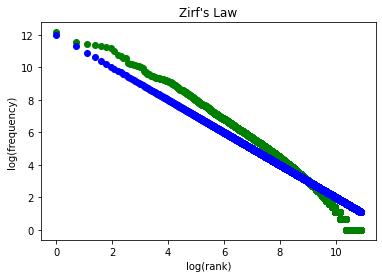

In [ ]:
y = list(df_POS['frequency'].values) ## Frequency of the words in the corpus in the descending order
x = [i for i in range(1,len(y)+1)]   ## Rank of the words in the corpus
plt.scatter(np.log(x),np.log(y),color = "green")
plt.title("Zipf's Law")
plt.xlabel("log(rank)")
plt.ylabel("log(frequency)")
plt.scatter(np.log(x),12-np.log(x),color = "blue")
plt.show()

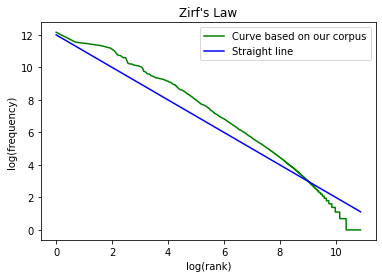

In [ ]:
y = list(df_POS['frequency'].values) ## Frequency of the words in the corpus in the descending order
x = [i for i in range(1,len(y)+1)]   ## Rank of the words in the corpus
plt.plot(np.log(x),np.log(y),color = "green",label ="Curve based on our corpus")
plt.title("Zipf's Law")
plt.xlabel("log(rank)")
plt.ylabel("log(frequency)")
plt.plot(np.log(x),12-np.log(x),color = "blue",label ="Straight line")
plt.legend()
plt.show()